# Outline
- Implement Random Forest using sklearn.tree.DecisionTreeClassifier
- Out-of-Bag Error
- Learn bagging and boosting in sklearn
- Visualize bias-variance for bagging and boosting
- Stacking

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Generate Toy dataset

In [2]:
from sklearn.datasets import make_classification

# randomly create dataset
X, y = make_classification(n_samples=2000, 
                           n_features=16, n_informative=6,
                           n_clusters_per_class=2, flip_y=0.01, random_state=1007)

print(X.shape)

(2000, 16)


### Random Forest
Build random forest based on sklearn.tree.DecisionTreeClassifier

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC

class RandomForest():
    def __init__(self, n_trees=10, max_features='sqrt', oob_score=False):
        self.n_trees = n_trees
        self.oob_score = oob_score
        self.trees = [DTC(max_features=max_features) for _ in range(n_trees)]

    # compatible with Sklearn fit api, train model with X and y
    # X: training data of shape [n_sample, d_feature]
    # y: class label of shape [n_sample]
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]
            
        if self.oob_score:
            proba_oob = np.zeros((n_samples, self.n_classes))
            
        for tree in self.trees:
            # get bagging samples (Bagging)
            sampled_idx = np.random.randint(0, n_samples, n_samples)
            if self.oob_score:
                unsampled_mask = np.bincount(sampled_idx, minlength=n_samples) == 0
                unsampled_idx = np.arange(n_samples)[unsampled_mask]
                                         
            tree.fit(X[sampled_idx], y[sampled_idx])            
            if self.oob_score:
                proba_oob[unsampled_idx] += tree.predict_proba(X[unsampled_idx])
                
        if self.oob_score:
            self.oob_score_ = np.mean(y == np.argmax(proba_oob, axis=1))
    
    # compatible with Sklearn predict api, get class prediction with X
    # X: data of shape [n_sample, d_feature]
    # return: prediction of shape [n_sample]        
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)
    
    # compatible with Sklearn predict_proba api, get class predict probability with X
    # X: data of shape [n_sample, d_feature]
    # return: predict probability of shape [n_sample, n_class]
    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], self.n_classes))
        for tree in self.trees:
            proba += tree.predict_proba(X)
        proba /= self.n_trees
        return proba
    # compatible with Sklearn score api, compute classification accuracy using trained model
    # X: data of shape [n_sample, d_feature]
    # y: class label of shape [n_sample]
    # return: accuracy
    def score(self, X, y):
        return np.mean(y == self.predict(X))

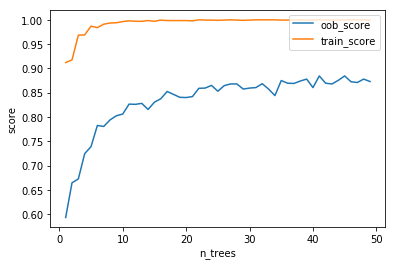

In [4]:
# Visualization for Bagging (reduce variance)
n_trees = []
oob_score = []
train_score = []
for n_tree in range(1, 50):
    rf = RandomForest(n_trees = n_tree, oob_score=True)
    rf.fit(X, y)
    n_trees.append(n_tree)
    oob_score.append(rf.oob_score_)
    train_score.append(rf.score(X, y))
    
plt.plot(n_trees, oob_score, label='oob_score')
plt.plot(n_trees, train_score, label='train_score')
plt.ylabel('score')
plt.xlabel('n_trees')
plt.legend(loc="upper right")
plt.show()

In [5]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(DTC(max_features='sqrt'), n_estimators=10, oob_score=True)
bc.fit(X, y)
print(bc.oob_score_)

0.818


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:610: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:615: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


### Sklearn GradientBoostingClassifier

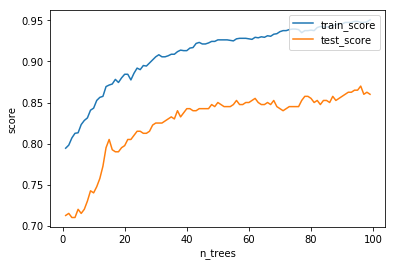

In [6]:
# Visualization for Boosting (reduce bias)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_trees = []
train_score = []
test_score = []

for n_estimators in range(1, 100, 1):
    gbc = GBC(n_estimators=n_estimators, max_depth=3)
    gbc.fit(X_train, y_train)
    n_trees.append(n_estimators)
    train_score.append(gbc.score(X_train, y_train))
    test_score.append(gbc.score(X_test, y_test))
    
plt.plot(n_trees, train_score, label='train_score')
plt.plot(n_trees, test_score, label='test_score')
plt.ylabel('score')
plt.xlabel('n_trees')
plt.legend(loc="upper right")
plt.show()

### Build Ensemble Classifier

In [7]:
from sklearn.model_selection import KFold

class EnsembleClassifier():
    # classifiers: list of base classifiers (with method fit, score, predict_proba)
    def __init__(self, classifiers):
        self.classifiers = classifiers
        
    def fit(self, X, y):
        raise NotImplementedError
        
    def predict(self, X):
        raise NotImplementedError
        
    def score(self, X, y):
        raise NotImplementedError
    
    # get score of each base classifier
    # X: data of shape [n_sample, d_feature]
    # y: class label of shape [n_sample]
    # return: list of scores
    def score_classifiers(self, X, y):
        scores = []
        for classifier in self.classifiers:
            scores.append(classifier.score(X, y))
        return scores
    
class AverageClassifier(EnsembleClassifier):
    def fit(self, X, y):
        self.n_classes = np.unique(y).shape[0]
    
        for classifier in self.classifiers:
            classifier.fit(X, y)
    
    def predict(self, X):
        predict_proba = np.zeros((X.shape[0], self.n_classes))
        for classifier in self.classifiers:
            predict_proba += classifier.predict_proba(X)
        return np.argmax(predict_proba, axis=1)
        
    def score(self, X, y):
        return np.mean(y == self.predict(X))

In [8]:
class StackingClassifier(EnsembleClassifier):
    # meta_classifier: classifier for second-level prediction
    # concat_feature: whether to use original feature
    # kfold: split training data into kfold, train on k-1 folds, get prediction on the rest one
    def __init__(self, classifiers, meta_classifier, concat_feature=False, kfold=5):
        super().__init__(classifiers)
        self.meta_classifier = meta_classifier
        self.concat_feature = concat_feature
        self.kf = KFold(n_splits=kfold)
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = np.unique(y).shape[0]
        
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((n_samples, 0))
        for classifier in self.classifiers:
            predict_proba = np.zeros((n_samples, self.n_classes))
            for train_idx, test_idx in self.kf.split(X):
                classifier.fit(X[train_idx], y[train_idx])
                predict_proba[test_idx] = classifier.predict_proba(X[test_idx])
            features = np.c_[features, predict_proba]
        
        self.meta_classifier.fit(features, y)
    
        # retrain classifiers with all training data
        for classifier in self.classifiers:
            classifier.fit(X, y)
    
    def _get_features(self, X):
        if self.concat_feature:
            features = X
        else:
            features = np.zeros((X.shape[0], 0))
        for classifier in self.classifiers:
            features = np.c_[features, classifier.predict_proba(X)]
        return features
    
    def predict(self, X):
        return self.meta_classifier.predict(self._get_features(X))
        
    def score(self, X, y):
        return self.meta_classifier.score(self._get_features(X), y)

In [10]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC

rf = RFC(n_estimators=10)
knc = KNC()
lr = LR(C=2, solver='liblinear', multi_class="ovr")

ac = AverageClassifier([rf, knc])
ac.fit(X_train, y_train)
print("BaseClassifiers: ", ac.score_classifiers(X_test, y_test))
print("AverageClassifiers: %.6f" % ac.score(X_test, y_test))

sc = StackingClassifier([rf, knc], lr, concat_feature=False)
sc.fit(X_train, y_train)
print("StackingClassifiers: %.6f" % sc.score(X_test, y_test))

sc_concat = StackingClassifier([rf, knc], lr, concat_feature=True)
sc_concat.fit(X_train, y_train)
print("StackingClassifiers with original features: %.6f" % sc_concat.score(X_test, y_test))

BaseClassifiers:  [0.85, 0.8375]
AverageClassifiers: 0.857500
StackingClassifiers: 0.842500
StackingClassifiers with original features: 0.867500
